In [61]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

# == Pre_defined state ==
pauli_x = np.array([ [0, 1], [1, 0]])
pauli_y = np.array([ [0, -1.j], [1.j, 0]])
pauli_z = np.array([ [1, 0], [0, -1]])

# state = (00 + 01 + 10 + 11)/2 = kron(|0> + |1>)/sqrt(2) , (|0> + |1>)/sqrt(2) )
state_super_pos = np.kron( (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) , (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) )
rho_super_pos = np.kron(state_super_pos, state_super_pos.conj().T) 
# state_super_pos, state_super_pos.con().T has different dimension 


# print(rho_super_pos)
# print(state_super_pos)

# bell state = (|00> + |11>) / 2
state_bell = ( np.kron( np.array([ [1], [0] ]) , np.array([ [1], [0] ]) ) +  np.kron( np.array([ [0], [1] ]) , np.array([ [0], [1] ]) ) )/np.sqrt(2) 
# rho_bell = state_bell @ state_bell.conj().T
rho_bell = np.kron(state_bell , state_bell.conj().T)

print('bell_state:\n',rho_bell)

bell_state:
 [[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


Hamiltonian:
   (1) [Z0 Z1] 



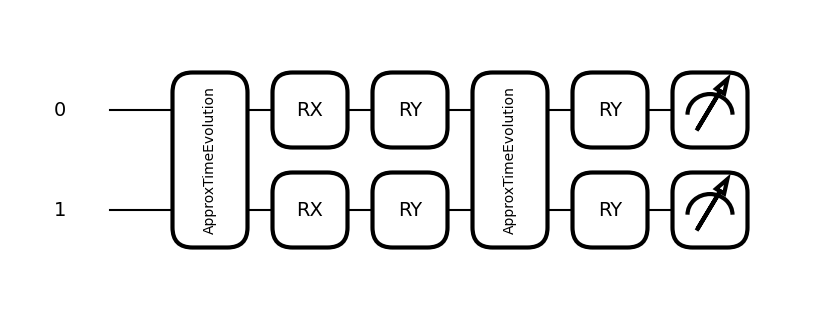

In [62]:
# == Hamiltonian setup ==
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)
print('Hamiltonian:\n', hamiltonian,'\n')


# Quantum circuit
@qml.qnode(dev)
def circuit(theta_init, tau_1, tau_2):
    
	qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
	qml.RX(theta_init, wires = 0)    
	qml.RX(theta_init, wires = 1)    
	 
	qml.RY(-np.pi/2, wires = 0)    
	qml.RY(-np.pi/2, wires = 1)   
	
	qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
	
	qml.RY(np.pi/2, wires = 0)    
	qml.RY(np.pi/2, wires = 1) 

	return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit)(0,0,1)

# Get demsity matrix from the circuit
time_for_evo = np.pi/4
rho_from_circuit = (circuit(time_for_evo,time_for_evo,time_for_evo))

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1748/263587641.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1748/263587641.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


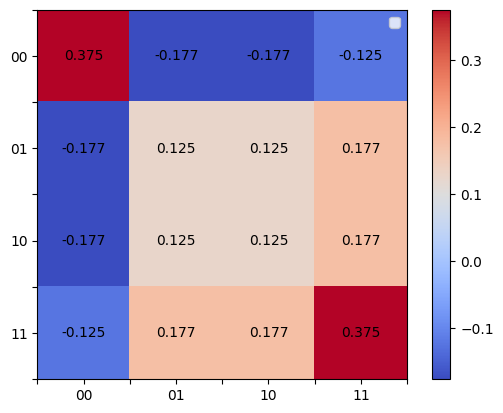

density_matrix_from_circuit:
 [[ 0.375    +0.00000000e+00j -0.1767767+1.25000000e-01j -0.1767767+1.25000000e-01j -0.125    +3.53553391e-01j]
 [-0.1767767-1.25000000e-01j  0.125    +0.00000000e+00j  0.125    -1.96261557e-17j  0.1767767-1.25000000e-01j]
 [-0.1767767-1.25000000e-01j  0.125    +1.96261557e-17j  0.125    +0.00000000e+00j  0.1767767-1.25000000e-01j]
 [-0.125    -3.53553391e-01j  0.1767767+1.25000000e-01j  0.1767767+1.25000000e-01j  0.375    +0.00000000e+00j]]


In [63]:
# == Plot density matrix ==
# circuit density matrix

selected_density_matrix = rho_from_circuit.real

state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'11',"",'10',"",'01',"",'00']

fig, ax = plt.subplots(1,1)
plt.imshow(selected_density_matrix, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)


for (j,i),label in np.ndenumerate(selected_density_matrix):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()


print('density_matrix_from_circuit:\n',rho_from_circuit)

In [64]:
# == Optimization begin ==

def calculate_fidelity(parameters):
    theta, tau_1, tau_2 = parameters 
    fidelity = qml.math.fidelity(rho_bell, circuit(theta, tau_1, tau_2))
    
    return 1-fidelity


Init_parameters = np.pi/8, np.pi/4, np.pi/4
result = sp.optimize.minimize(calculate_fidelity, Init_parameters, method='SLSQP')

print(result,'\n')
print('fidelity:', -1*(result.fun-1))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5000000000000004
       x: [-6.633e-09  7.797e-01  5.612e-01]
     nit: 6
     jac: [-1.490e-08  0.000e+00  0.000e+00]
    nfev: 45
    njev: 6 

fidelity: 0.49999999999999956


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/quantum.py:46: UserWarning: Argument passed to fidelity has shape (4, 4) and will be interpreted as a density matrix. If a batched state vector was intended, please call qml.math.dm_from_state_vector first, as passing state vectors to fidelity is deprecated.
  warnings.warn(


/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1748/2371638685.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1748/2371638685.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


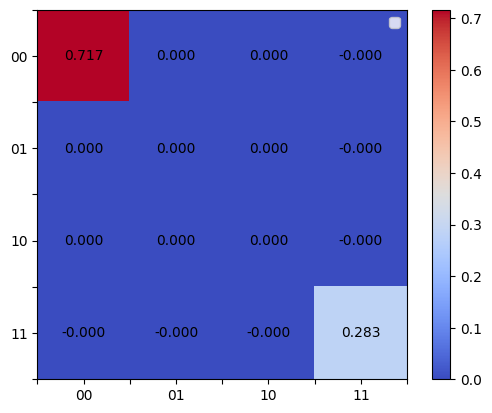

In [65]:
# == After optimize ==

selected_density_matrix = circuit(result.x[0],result.x[1],result.x[2]).real

state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'11',"",'10',"",'01',"",'00']

fig, ax = plt.subplots(1,1)
plt.imshow(selected_density_matrix, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)


for (j,i),label in np.ndenumerate(selected_density_matrix):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()